<a href="https://colab.research.google.com/github/graphitical/HeadsUP/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install detectron2

In [1]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__)

gpu_available = torch.cuda.is_available()
if gpu_available:
  device = 'cuda'
else:
  device = 'cpu'
print('CUDA enabled:', gpu_available)

!gcc --version
# opencv is pre-installed on colab

1.7.0+cu101
CUDA enabled: True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



# Mount Google Drive

In [4]:
# Use this to mount your google account that has
# access to the shared drive
import os, sys, urllib.request
from google.colab import drive
drive.mount('/gdrive')

# Change dir to shared drive
BASE_PATH = '/gdrive/Shareddrives/deep learning and PDF accessibility/'
os.chdir(BASE_PATH)
!pwd

Mounted at /gdrive
/gdrive/Shareddrives/deep learning and PDF accessibility


# Load model

## Helper functions

In [5]:
def setup_cfg(config, weights, thresh = 0.5, device = 'cpu'):
    # load config from file and command-line arguments
    cfg = get_cfg()
    cfg.merge_from_file(config)
    # Set score_threshold for builtin models
    cfg.MODEL.WEIGHTS = weights
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = thresh
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = thresh
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = thresh
    cfg.MODEL.DEVICE = device
    cfg.freeze()
    return cfg

In [6]:
# These are detection class defintions
# Examples are text, title, etc.
# Will need to expand for our training
MetadataCatalog.get("dla_val").thing_classes = ['text','title','list','table','figure']

# BIG MODEL
config = BASE_PATH + 'configs/DLA_mask_rcnn_X_101_32x8d_FPN_3x.yaml'
weights = BASE_PATH + 'configs/resnext101.pth'

# LITTLE MODEL
# config = BASE_PATH + 'configs/DLA_mask_rcnn_R_50_FPN_3x.yaml'
# weights = BASE_PATH + 'configs/resnet50.pth'

cfg = setup_cfg(config, weights, device=device)
predictor = DefaultPredictor(cfg)

WARNING [12/10 00:34:34 d2.config.compat]: Config '/gdrive/Shareddrives/deep learning and PDF accessibility/configs/DLA_mask_rcnn_X_101_32x8d_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


# Predict

In [7]:
# Likely want to loop here, but can hard code for debugging
fname = BASE_PATH + 'temp/ASSETS_paper/ASSETS_paper-page-1.png'
im = cv2.imread(fname)
# cv2_imshow(im)
outputs = predictor(im)
# print(outputs)

/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


## Visualize

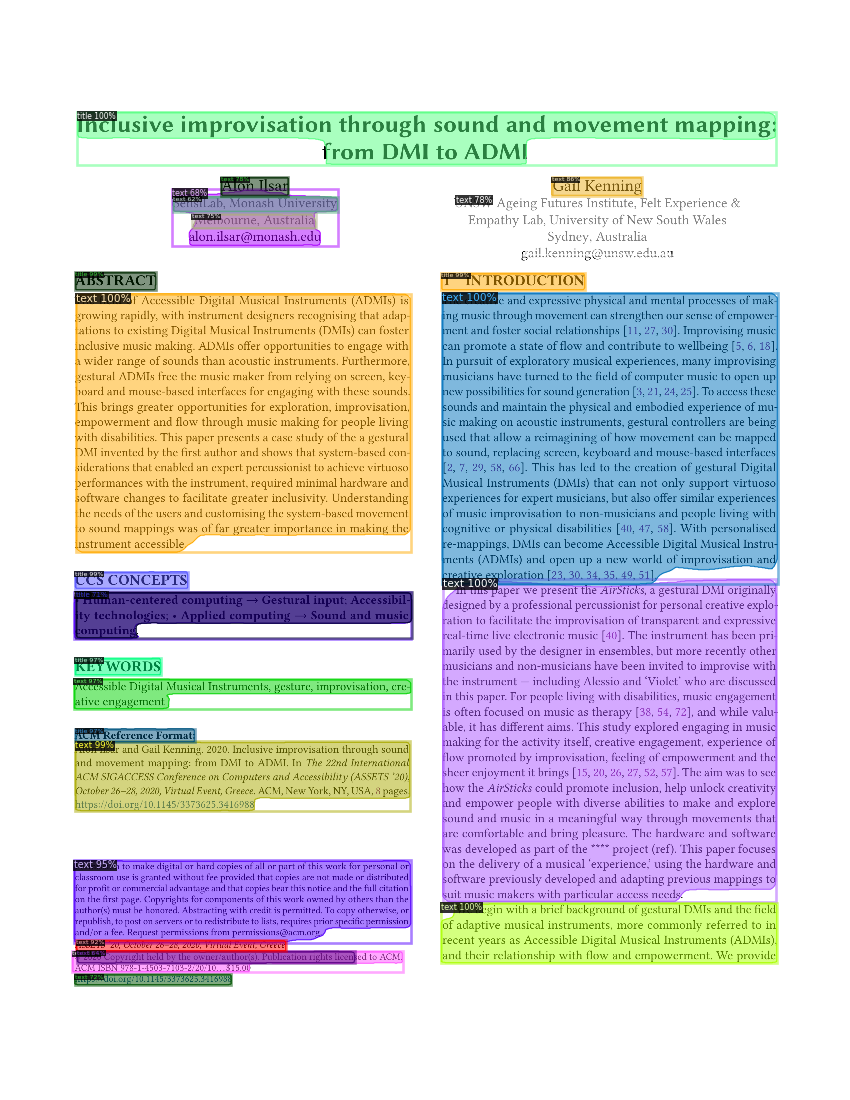

In [8]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get("dla_val"), scale=0.5)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Useful references
1. [Fine tune model](https://github.com/hpanwar08/detectron2/issues/25)
